In [1]:
import os
os.getcwd()

# Change directory to main repository directory in order to install modules
os.chdir(f"{os.environ['HOME']}/Code/jwst/")

In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision

from matplotlib import pyplot as plt
# from plotly import express as px
# from sklearn.manifold import TSNE
# from skimage.transform import rotate
from torch.utils.data import DataLoader, random_split
from torch import from_numpy, nn
from torch.nn import functional as F
from torchvision.utils import make_grid
from torchvision import transforms
from tqdm import tqdm
# from time import perf_counter

from variational_autoencoder.model import VariationalAutoencoder

In [3]:
TRAIN_DATA_PATH = f"{os.environ['HOME']}/Code/jwst/data/train/"
TEST_DATA_PATH = f"{os.environ['HOME']}/Code/jwst/data/test/"
VALIDATION_DATA_PATH = f"{os.environ['HOME']}/Code/jwst/data/validation/"
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
])

# Train data
train_dataset_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
train_loader_data = torch.utils.data.DataLoader(train_dataset_data, batch_size=BATCH_SIZE, shuffle=True)

train_length_data = len(train_dataset_data)

# Test data
test_dataset_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform)
test_loader_data = torch.utils.data.DataLoader(test_dataset_data, batch_size=BATCH_SIZE, shuffle=True)

test_length_data = len(test_dataset_data)

# Validation data
validation_dataset_data = torchvision.datasets.ImageFolder(root=VALIDATION_DATA_PATH, transform=transform)
validation_loader_data = torch.utils.data.DataLoader(validation_dataset_data, batch_size=BATCH_SIZE, shuffle=True)

validation_length_data = len(validation_dataset_data)

# print info
print(f"Number of training data: {train_length_data}")
print(f"Number of test data: {len(test_dataset_data)}")
print(f"Number of validation data: {len(validation_dataset_data)}")
print(f"Image pixels: ({train_dataset_data[0][0].shape[1]}, {train_dataset_data[0][0].shape[2]})")
print(f"Number of classes: {len(train_dataset_data.classes)}\n")



Number of training data: 224
Number of test data: 28
Number of validation data: 28
Image pixels: (256, 2048)
Number of classes: 1



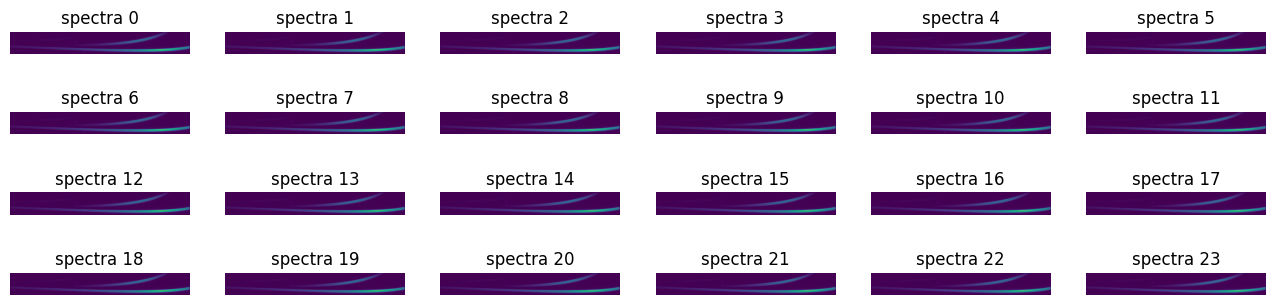

In [4]:
def plot_dataset(rows, dataset, axes_on=False):
    """Function to plot multiple sources from a list of images, using
    the list index as the label."""
    cols = 6
    img_count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2.7, rows * 1))

    for i in range(rows):
        for j in range(cols):        
            if img_count < rows * cols:
                axes[i, j].imshow(dataset[img_count][0][0].data, origin="lower", cmap="viridis")
                axes[i, j].axis("off")
                axes[i, j].title.set_text(f"spectra {img_count}")
                img_count+=1
            
plot_dataset(4, train_dataset_data)

In [5]:
# conv1 = nn.Conv2d(1, 8, 3, stride=1, padding=0)
# conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=0)
# conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=0)


# def imshow(image):
#     image = image / 2 + 0.5
#     np_image = image.numpy()
#     plt.imshow(np.transpose(np_image, (1, 2, 0)), cmap="viridis")
#     plt.grid(False)
#     plt.show()
    
# data_iter = iter(train_loader_data)
# images, labels = data_iter.next_data()

# imshow(torchvision.utils.make_grid(images))

In [ ]:
# Set the random seed for reproducible results
torch.manual_seed(0)

# Check if the GPU is available
train_device = torch.device("cpu") if torch.cuda.is_available() else torch.device("cpu")
print(f"Selected device: {train_device}")

# Use Autoencoder class to instantiate a model
# input_dims is 1 as the input image has 1 channel
variational_autoencoder = VariationalAutoencoder(input_dims=1, latent_dims=128).to(train_device)

# Define the optimizer
# train_optimizer = torch.optim.SGD(variational_autoencoder.parameters(), lr=1e-5, weight_decay=1e-05)
LEARNING_RATE = 0.0001
train_optimizer = torch.optim.Adam(variational_autoencoder.parameters(), lr=LEARNING_RATE)

Selected device: cpu


In [7]:
print(variational_autoencoder)

VariationalAutoencoder(
  (encoder): Encoder(
    (x1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (x2): ReLU(inplace=True)
    (x3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (x4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (x5): ReLU(inplace=True)
    (x6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (x7): ReLU(inplace=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fully_connected_mu): Linear(in_features=16629888, out_features=128, bias=True)
    (fully_connected_sigma): Linear(in_features=16629888, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (decoder_fc): Linear(in_features=128, out_features=16629888, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 254, 2046))
    (conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): R

In [8]:
# Define the loss function
def loss_function(image, reconstruction, mean, log_variance):
    """This function will add the reconstruction loss and the KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)"""
    
    # Binary cross entropy loss
    criterion = nn.BCELoss(reduction="sum")
    bce_loss = criterion(reconstruction, image)
    # KL Divergence term
    kl_divergence = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())

    return bce_loss + kl_divergence

def train(model, device, dataset, dataloader, loss_method, optimizer):
    """Function to calculate the training loss for a single epoch."""

    # Set train mode for the model
    model.train()
    train_loss = 0

    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset) / dataloader.batch_size)):

        # Move tensor to the proper device
        data = data[0].to(device)
        optimizer.zero_grad()
        
        # Compute reconstructions
        output, mu, log_var = model(data)
        
        # Evaluate loss
        loss = loss_method(data, output, mu, log_var)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(dataloader)

def validate(model, device, dataset, dataloader, loss_method):
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset) / dataloader.batch_size)):
            # Move tensor to the proper device
            data = data[0].to(device)
            # Compute reconstructions
            output, mu, log_var = model(data)

            # Evaluate loss
            loss = loss_method(data, output, mu, log_var)
            validation_loss += loss.item()

            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                reconstructed_images = output

    return validation_loss / len(dataloader), reconstructed_images

In [9]:
training_loss = []
validation_loss = []
grid_images = []
EPOCHS = 40

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = train(
        variational_autoencoder, train_device, train_dataset_data, train_loader_data, loss_function, train_optimizer
    )
    validation_epoch_loss, reconstructed_images = validate(
        variational_autoencoder, train_device, test_dataset_data, validation_loader_data, loss_function
    )
    training_loss.append(train_epoch_loss)
    validation_loss.append(validation_epoch_loss)

    #convert the reconstructed images to PyTorch image grid format
    # image_grid = make_grid(recon_images.detach().cpu())
    # grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Validation Loss: {validation_epoch_loss:.4f}")

Epoch 1 of 40


  0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([32, 8, 256, 2048])
torch.Size([32, 8, 256, 2048])
torch.Size([32, 16, 256, 2048])
torch.Size([32, 16, 256, 2048])
torch.Size([32, 16, 256, 2048])
torch.Size([32, 32, 254, 2046])
devon
torch.Size([32, 16629888])
torch.Size([32, 32, 254, 2046])
torch.Size([32, 16, 256, 2048])
torch.Size([32, 16, 256, 2048])
torch.Size([32, 16, 256, 2048])
torch.Size([32, 8, 256, 2048])


  0%|          | 0/7 [00:02<?, ?it/s]

torch.Size([32, 8, 256, 2048])
torch.Size([32, 8, 256, 2048])
torch.Size([32, 1, 256, 2048])


RuntimeError: all elements of target should be between 0 and 1

In [24]:
np.where(torch.isnan(train_dataset_data[0]))

TypeError: isnan(): argument 'input' (position 1) must be Tensor, not tuple

In [23]:
train_dataset_data[1]

(tensor([[[-0.7647, -0.7647, -0.7647,  ..., -0.7647, -0.7647, -0.7647],
          [-0.7647, -0.7647, -0.7647,  ..., -0.7647, -0.7647, -0.7647],
          [-0.7647, -0.7647, -0.7647,  ..., -0.7647, -0.7647, -0.7647],
          ...,
          [-0.7647, -0.7647, -0.7647,  ..., -0.7647, -0.7647, -0.7647],
          [-0.7647, -0.7647, -0.7647,  ..., -0.7647, -0.7647, -0.7647],
          [-0.7647, -0.7647, -0.7647,  ..., -0.7647, -0.7647, -0.7647]]]),
 0)